In [ ]:
import collections
import math
import random
import typing
from pathlib import Path

import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch import Tensor

from fastai.vision.all import \
    DataBlock, \
    ImageBlock, \
    CategoryBlock, \
    get_image_files, \
    RandomSplitter, \
    Resize, \
    parent_label, \
    Normalize, \
    vision_learner, \
    resnet18, \
    error_rate, \
    PILImage

In [16]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [17]:
batch_size = 128
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
def unnormalize(img_tensor: Tensor) -> Tensor:
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    return img_tensor * std + mean

In [19]:
def save_images(save_dir: Path, dataset: torchvision.datasets.CIFAR10, force: bool = False):
    if save_dir.exists() and save_dir.is_dir():
        if force:
            pass
        else:
            print('Images already saved, exiting early')
            return

    save_dir.mkdir(exist_ok=True, parents=True)

    for class_name in dataset.classes:
        (save_dir / str(class_name)).mkdir(exist_ok=True)

    for i in range(len(train_set)):
        image, label = train_set[i]
        class_name = train_set.classes[label]
        save_path = save_dir / class_name / f'{i}-{class_name}.png'
        unnormalized_image = unnormalize(image)
        torchvision.utils.save_image(unnormalized_image, save_path)

In [20]:
image_dir = Path('./images')
train_dir = image_dir / 'train'
test_dir = image_dir / 'test'

save_images(train_dir, train_set)
save_images(test_dir, test_set)

Images already saved, exiting early
Images already saved, exiting early


In [21]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2),
    get_y=parent_label
).dataloaders(train_dir, bs=32)

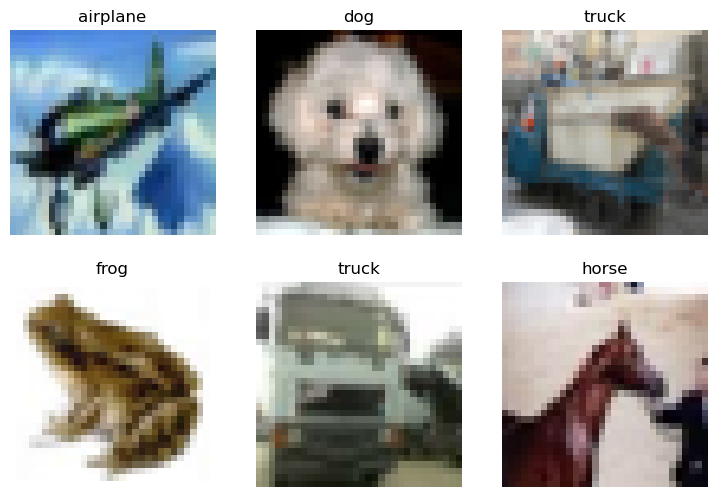

In [22]:
dls.show_batch(max_n=6)

In [23]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/daniel/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:15<00:00, 3.05MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.699903,1.552488,0.542800,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.976265,0.878498,0.298500,00:15
1,0.795201,0.692617,0.239000,00:15
2,0.588268,0.663471,0.229400,00:15


In [37]:
def get_random_file(root_dir: Path, extension: str = '.png'):
    files = list(root_dir.rglob(f'*{extension}'))
    if not files:
        raise FileNotFoundError()
    file = random.choice(files)
    return file, file.parent.name

correctly predicted airplane with 80.0384% confidence; actual label is airplane


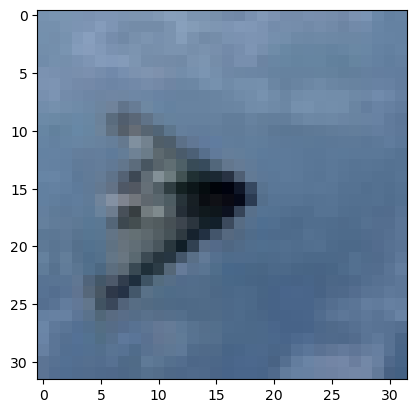

In [67]:
# image = PILImage.create(test_dir / 'airplane' / '29-airplane.png')
image_path, label = get_random_file(test_dir)
image = PILImage.create(image_path)
predicted_label, predicted_label_index, label_probabilities = learn.predict(image)
plt.imshow(image)
print(f'{"correctly" if predicted_label == label else "incorrectly"} predicted {predicted_label} with {label_probabilities[predicted_label_index] * 100:.4f}% confidence; actual label is {label}')
plt.show()